In [1]:
# Run validation if needed
# ! python validate.py --config_path 'configs/lr_config.yaml' --model 'GCN' --model_path 'saved_models/gcn/GCN_for_lrp01_2025-05-04_18-43-34.pt' --output_dir 'saved_metrics/gcn'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import geopandas as gpd
from data.hecras_data_retrieval import get_water_level
from data.shp_data_retrieval import get_cell_elevation
from utils.metric_utils import NSE

### Specific Model

In [3]:
saved_metrics_path = 'saved_metrics/hydrographnet/hydrographnet/HydroGraphNet_H401_metrics.npz'
saved_metrics = np.load(saved_metrics_path, allow_pickle=True)
rmse = saved_metrics['rmse']
rmse_flooded = saved_metrics['rmse_flooded']
mae = saved_metrics['mae']
mae_flooded = saved_metrics['mae_flooded']
nse = saved_metrics['nse']
nse_flooded = saved_metrics['nse_flooded']
csi = saved_metrics['csi']
csi_flooded = saved_metrics['csi_flooded']
pred = saved_metrics['pred']

In [4]:
print(f'RMSE: {np.mean(rmse):.4f}')
print(f'RMSE (flooded): {np.mean(rmse_flooded):.4f}')
print(f'MAE: {np.mean(mae):.4f}')
print(f'MAE (flooded): {np.mean(mae_flooded):.4f}')
print(f'NSE: {np.mean(nse):.4f}')
print(f'NSE (flooded): {np.mean(nse_flooded):.4f}')
print(f'CSI: {np.mean(csi):.4f}')
print(f'CSI (flooded): {np.mean(csi_flooded):.4f}')
print('Pred shape:', pred.shape)

RMSE: 0.0840
RMSE (flooded): 0.0849
MAE: 0.0524
MAE (flooded): 0.0529
NSE: 0.9525
NSE (flooded): 0.9523
CSI: 0.8206
CSI (flooded): 0.8206
Pred shape: (30, 4787, 1)


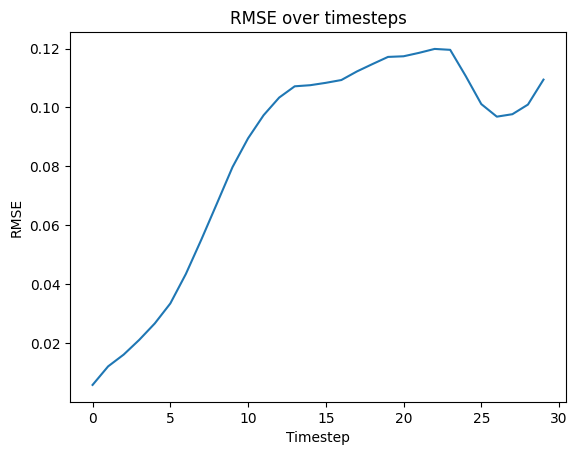

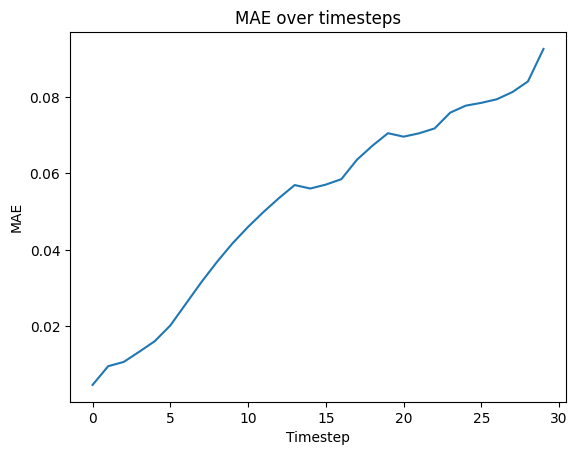

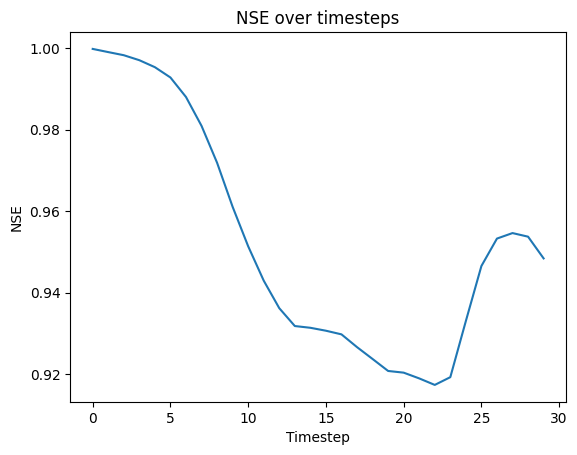

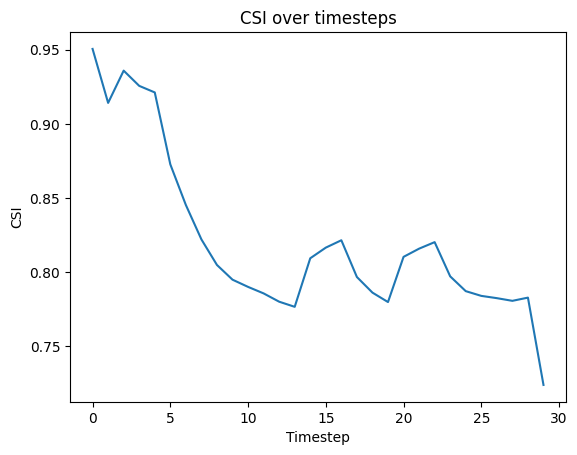

In [5]:
def plot(x, xlabel, ylabel, title):
    plt.plot(x)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

plot(rmse, xlabel='Timestep', ylabel='RMSE', title='RMSE over timesteps')
plot(mae, xlabel='Timestep', ylabel='MAE', title='MAE over timesteps')
plot(nse, xlabel='Timestep', ylabel='NSE', title='NSE over timesteps')
plot(csi, xlabel='Timestep', ylabel='CSI', title='CSI over timesteps')

In [6]:
rmse_flooded = saved_metrics['rmse_flooded']
mae_flooded = saved_metrics['mae_flooded']
nse_flooded = saved_metrics['nse_flooded']

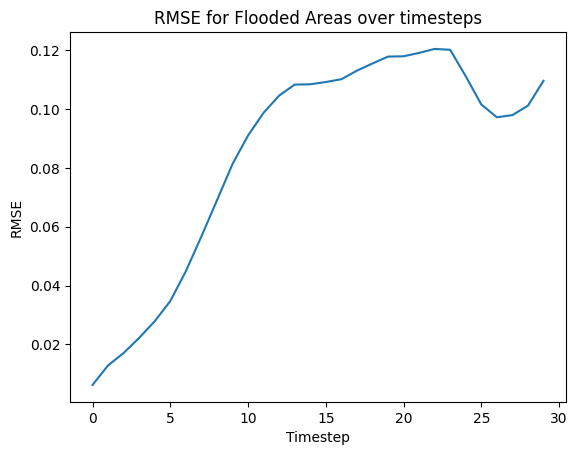

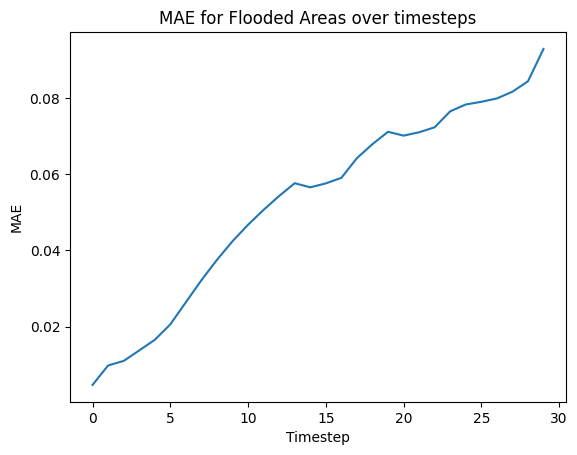

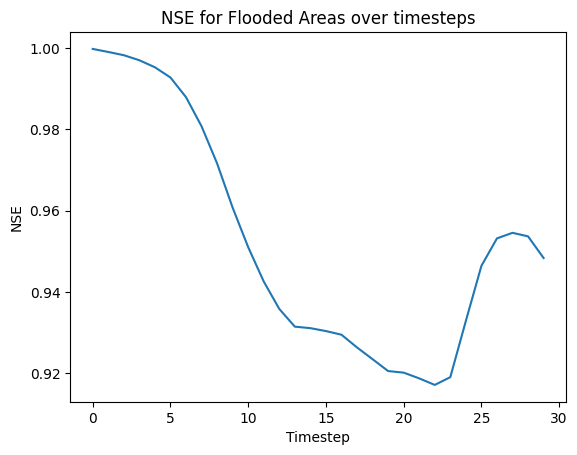

In [7]:
plot(rmse_flooded, xlabel='Timestep', ylabel='RMSE', title='RMSE for Flooded Areas over timesteps')
plot(mae_flooded, xlabel='Timestep', ylabel='MAE', title='MAE for Flooded Areas over timesteps')
plot(nse_flooded, xlabel='Timestep', ylabel='NSE', title='NSE for Flooded Areas over timesteps')

### Overall Metric Comparison

In [8]:
def get_hecras_water_depth(hecras_path: str, node_shp_path: str) -> np.ndarray:
    water_level = get_water_level(hecras_path)
    cell_elevation = get_cell_elevation(node_shp_path)
    water_depth = np.clip(water_level - cell_elevation, a_min=0, a_max=None)
    return water_depth

def get_hydrographnet_water_depth(interval: int = 1, skip: int = 72, num_nodes: int = 4787) -> np.ndarray:
    water_depth_path = "C:\\Users\\Carlo\\Documents\\School\\Masters\\NUS\\Dissertation\\HydroGraphNet\\outputs_phy\\data\\M80_WD_H401.txt"
    water_depth = np.loadtxt(water_depth_path, delimiter='\t')[skip::interval, :num_nodes]
    return water_depth

def get_hecras_gpd_node_df(node_shp_path: str):
    node_df = gpd.read_file(node_shp_path)
    return node_df

def get_hydrographnet_gpd_node_df():
    xy_coords_path  = "C:\\Users\\Carlo\\Documents\\School\\Masters\\NUS\\Dissertation\\HydroGraphNet\\outputs_phy\\data\\M80_XY.txt"
    xy_coords = np.loadtxt(xy_coords_path, delimiter='\t')
    geometry = gpd.points_from_xy(xy_coords[:, 0], xy_coords[:, 1])
    node_df = gpd.GeoDataFrame(geometry=geometry, crs='EPSG:4326')
    return node_df

In [21]:
# Global variables
# metric_paths = [
#     'saved_metrics/init/gcn/GCN_initp01_metrics.npz',
#     'saved_metrics/init/gat/GAT_initp01_metrics.npz',
#     'saved_metrics/init/gin/GIN_initp01_metrics.npz',
#     'saved_metrics/init/swegnn/SWEGNN_initp01_metrics.npz',
# ]
# metric_paths = [
#     'saved_metrics/lr/gcn/GCN_lrp01_metrics.npz',
#     'saved_metrics/lr/gat/GAT_lrp01_metrics.npz',
#     'saved_metrics/lr/gin/GIN_lrp01_metrics.npz',
#     'saved_metrics/lr/swegnn/SWEGNN_lrp01_metrics.npz',
# ]
# metric_paths = [
#     'saved_metrics/swegnn/orig/gcn/GCN_orig_metrics_1.npz',
#     'saved_metrics/swegnn/orig/swegnn/SWEGNN_orig_metrics_1.npz',
# ]
# metric_paths = [
#     # 'saved_metrics/hydrographnet/gcn/GCN_H401_metrics.npz',
#     'saved_metrics/hydrographnet/gat/GAT_H401_metrics.npz',
#     # 'saved_metrics/hydrographnet/gin/GIN_H401_metrics.npz',
#     'saved_metrics/hydrographnet/swegnn/SWEGNN_H401_metrics.npz',
#     'saved_metrics/hydrographnet/hydrographnet/HydroGraphNet_H401_metrics.npz',
# ]
metric_paths = [
    'saved_metrics/hydrographnet/gat/base_400events/GAT_H403_metrics.npz',
    'saved_metrics/hydrographnet/gat/physics/GAT_H403_metrics.npz',
    # 'saved_metrics/hydrographnet/gat/physics_edge/GAT_H401_metrics.npz',
    # 'saved_metrics/hydrographnet/gat/physics_4head/GAT_H401_metrics.npz',
    'saved_metrics/hydrographnet/swegnn/hydrographnet_400events/SWEGNN_H403_metrics.npz',
    'saved_metrics/hydrographnet/hydrographnet/400_events_100_epochs/HydrographNet_H403_metrics.npz',
]


# init_hecras_path = 'data/datasets/init/initp01/raw/Model_01.p01.hdf'
# init_node_shp_path = 'data/datasets/init/initp01/raw/cell_centers.shp'
# water_depth = get_hecras_water_depth(init_hecras_path, init_node_shp_path)
# node_df = get_hecras_gpd_node_df(init_node_shp_path)

# lr_hecras_path = 'data/datasets/lr/lrp01/raw/M01.p01.hdf'
# lr_node_shp_path = 'data/datasets/lr/lrp01/raw/cell_centers.shp'
# water_depth = get_hecras_water_depth(lr_hecras_path, lr_node_shp_path)
# node_df = get_hecras_gpd_node_df(lr_node_shp_path)

water_depth = get_hydrographnet_water_depth()
node_df = get_hydrographnet_gpd_node_df()

In [22]:
# Double check targets are the same
EPS = 1e-5
comparison_target = None
for path in metric_paths:
    print('Checking target for', path)
    target = np.load(path, allow_pickle=True)['target']
    if comparison_target is None:
        comparison_target = target
    else:
        assert np.all((comparison_target - target) < EPS), f'Targets are not equal for {path}'

Checking target for saved_metrics/hydrographnet/gat/base_400events/GAT_H403_metrics.npz
Checking target for saved_metrics/hydrographnet/gat/physics/GAT_H403_metrics.npz
Checking target for saved_metrics/hydrographnet/swegnn/hydrographnet_400events/SWEGNN_H403_metrics.npz
Checking target for saved_metrics/hydrographnet/hydrographnet/400_events_100_epochs/HydrographNet_H403_metrics.npz


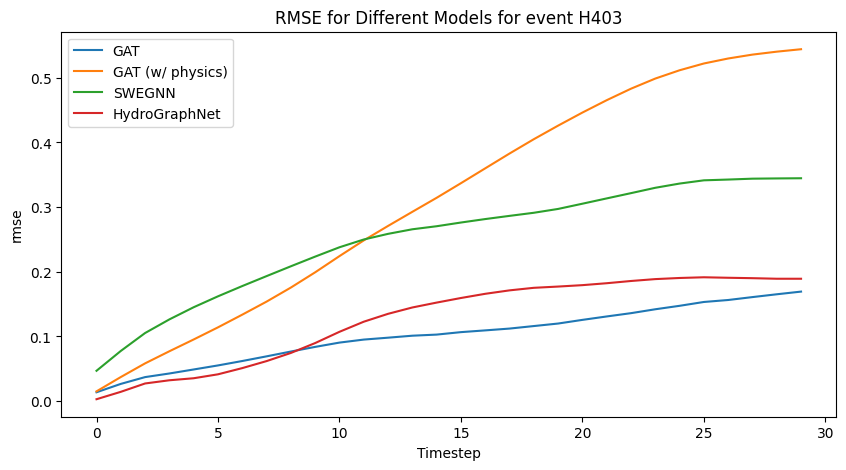

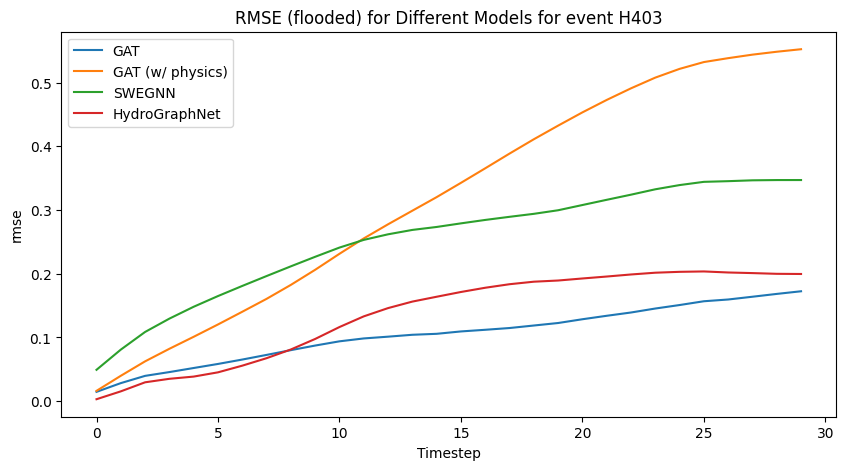

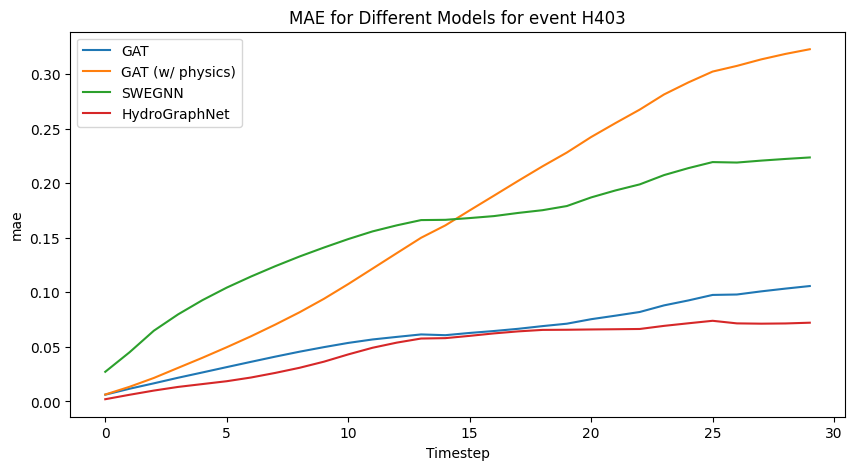

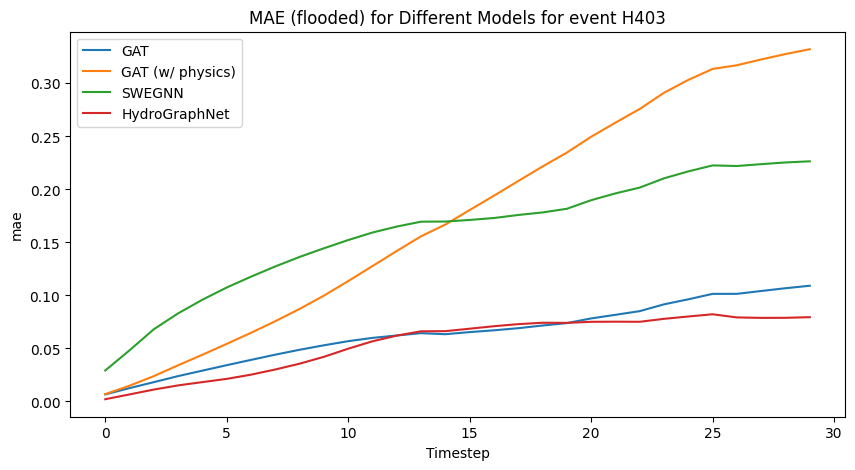

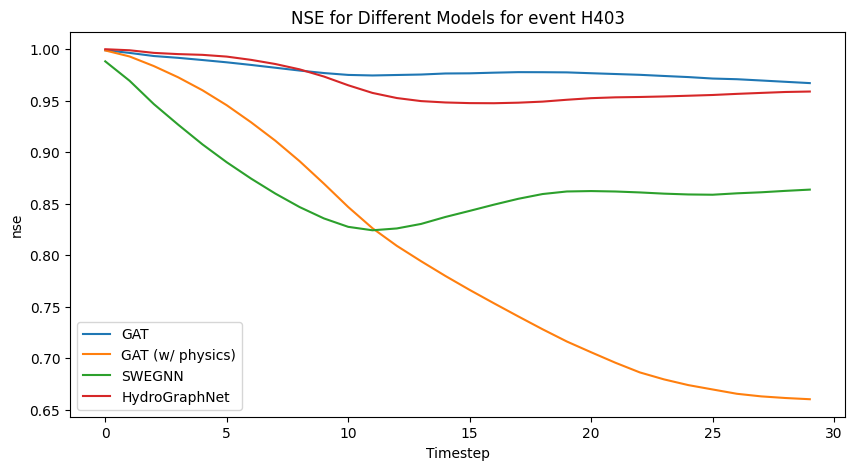

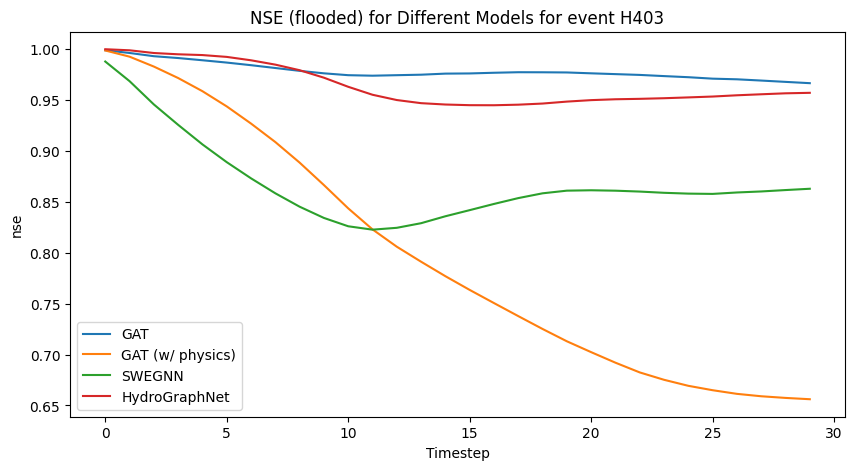

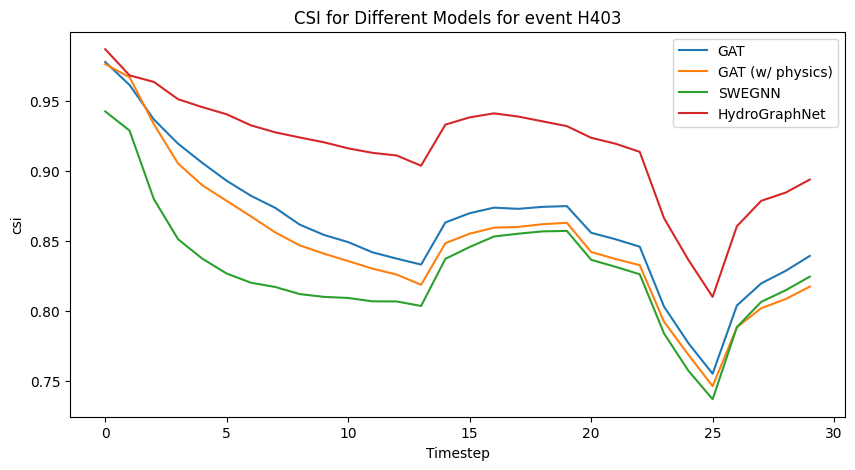

In [23]:
def plot_metric_for_all_models(metric_paths: list[str], metric: str, labels: list[str] = None):
    split_metric = metric.split('_') 
    metric_name = split_metric[0].upper() + (f' ({split_metric[1]})' if len(split_metric) > 1 else '')
    event_name = metric_paths[0].split('/')[-1].split('_')[1]

    plt.figure(figsize=(10, 5))
    plt.title(f'{metric_name} for Different Models for event {event_name}')
    plt.xlabel('Timestep')
    plt.ylabel(split_metric[0])

    data_shape = None
    for i, path in enumerate(metric_paths):
        label = path.split('/')[-1].split('_')[0]
        data = np.load(path, allow_pickle=True)[metric]
        # print(f'Average {metric_name} for {label}: {np.mean(data):.4f}')
        if data_shape is None:
            data_shape = data.shape
        assert data.shape == data_shape, f"Data shape mismatch for model {label}: {data.shape} vs {data_shape}"

        if len(path.split('/')[-1].split('_')) == 4:
            label = f'{label} ({path.split('/')[-1].split('_')[3]})'

        if labels is not None:
            label = labels[i] if i < len(labels) else label

        plt.plot(data, label=label)

    plt.legend()
    plt.show()

# labels=None
labels = ['GAT', 'GAT (w/ physics)', 'SWEGNN', 'HydroGraphNet']
plot_metric_for_all_models(metric_paths, 'rmse', labels=labels)
plot_metric_for_all_models(metric_paths, 'rmse_flooded', labels=labels)
plot_metric_for_all_models(metric_paths, 'mae', labels=labels)
plot_metric_for_all_models(metric_paths, 'mae_flooded', labels=labels)
plot_metric_for_all_models(metric_paths, 'nse', labels=labels)
plot_metric_for_all_models(metric_paths, 'nse_flooded', labels=labels)
plot_metric_for_all_models(metric_paths, 'csi', labels=labels)

### Node Analysis

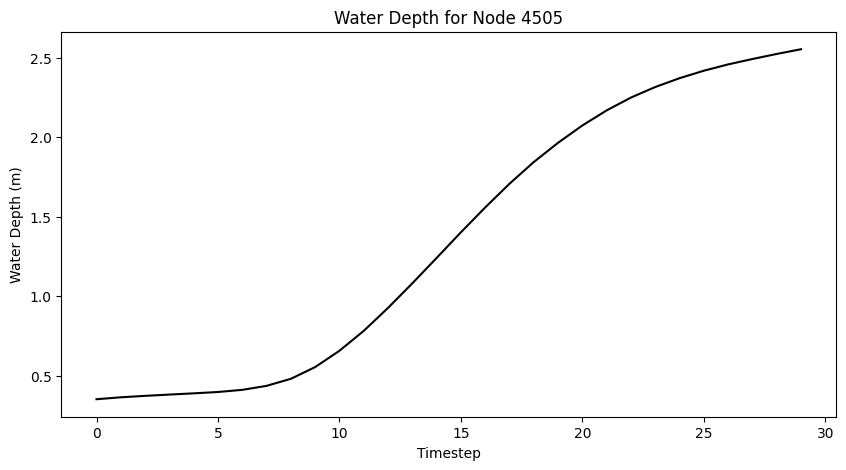

Peak water depth for node 4505: 3.075973988 (timestep 85)


In [ ]:
# NODE_IDX = 0

# HydroGraphNet
NODE_IDX = 2573 # High water level node
# NODE_IDX = 4659 # High water level node
# NODE_IDX = 4505 # High water level node
# NODE_IDX = 3939 # High water level node

# HEC-RAS LR
# NODE_IDX = 3536 # Upstream node index
# NODE_IDX = 10593 # Midstream node index
# NODE_IDX = 17686 # Downstream node index

def plot_water_depth_for_node(node_idx: int, water_depth: np.ndarray, num_timesteps: int = None):
    if num_timesteps is None:
        num_timesteps = water_depth.shape[0]

    plt.figure(figsize=(10, 5))
    plt.title(f'Water Depth for Node {node_idx}')
    plt.xlabel('Timestep')
    plt.ylabel('Water Depth (m)')
    plt.plot(water_depth[:num_timesteps, node_idx], color='black')
    plt.show()

num_timesteps = 30
ground_truth = np.load(metric_paths[0], allow_pickle=True)['target']
plot_water_depth_for_node(NODE_IDX, ground_truth, num_timesteps=num_timesteps)
peak_wd = water_depth[:, NODE_IDX].max()
peak_wd_timestep = water_depth[:, NODE_IDX].argmax()
print(f"Peak water depth for node {NODE_IDX}: {peak_wd} (timestep {peak_wd_timestep})")

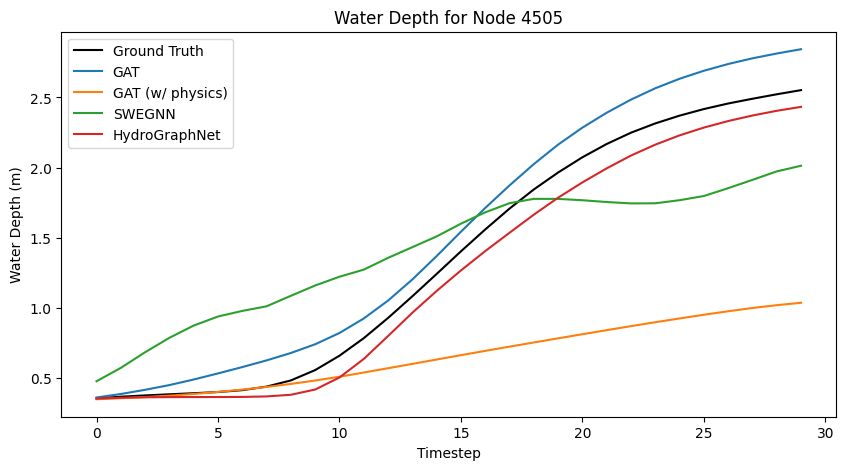

In [41]:
def plot_node_water_depth_for_all_models(metric_paths: list[str], node_idx: int, ground_truth: np.ndarray = None, num_timesteps: int = None, labels: list[str] = None):
    plt.figure(figsize=(10, 5))
    plt.title(f'Water Depth for Node {node_idx}')
    plt.xlabel('Timestep')
    plt.ylabel('Water Depth (m)')

    if ground_truth is not None:
        if num_timesteps is None:
            num_timesteps = ground_truth.shape[0]

        plt.plot(ground_truth[:num_timesteps, node_idx], label='Ground Truth', color='black')

    data_shape = None
    for i, path in enumerate(metric_paths):
        pred = np.load(path, allow_pickle=True)['pred']
        if num_timesteps is None:
            num_timesteps = pred.shape[0]

        if data_shape is None:
            data_shape = pred.shape
        assert pred.shape == data_shape, f"Data shape mismatch for path {path}: {pred.shape} vs {data_shape}"

        label = path.split('/')[-1].split('_')[0]

        if labels is not None:
            label = labels[i] if i < len(labels) else label

        plt.plot(pred[:num_timesteps, node_idx], label=label)

    plt.legend()
    plt.show()

ground_truth = np.load(metric_paths[0], allow_pickle=True)['target']
plot_node_water_depth_for_all_models(metric_paths, NODE_IDX, ground_truth=ground_truth, num_timesteps=num_timesteps, labels=labels)

In [42]:
node_gt = torch.Tensor(ground_truth[:num_timesteps, NODE_IDX])
for path in metric_paths:
    pred = np.load(path, allow_pickle=True)['pred']
    node_pred = torch.Tensor(pred[:num_timesteps, NODE_IDX])
    print(node_pred.shape, node_gt.shape)
    nse = NSE(node_pred, node_gt)
    label = path.split('/')[-1].split('_')[0]
    print(f'NSE for {label} at node {NODE_IDX}: {nse:.4f}')

torch.Size([30, 1]) torch.Size([30, 1])
NSE for GAT at node 4505: 0.9482
torch.Size([30, 1]) torch.Size([30, 1])
NSE for GAT at node 4505: -0.2419
torch.Size([30, 1]) torch.Size([30, 1])
NSE for SWEGNN at node 4505: 0.7093
torch.Size([30, 1]) torch.Size([30, 1])
NSE for HydrographNet at node 4505: 0.9775


### Timestep Analysis

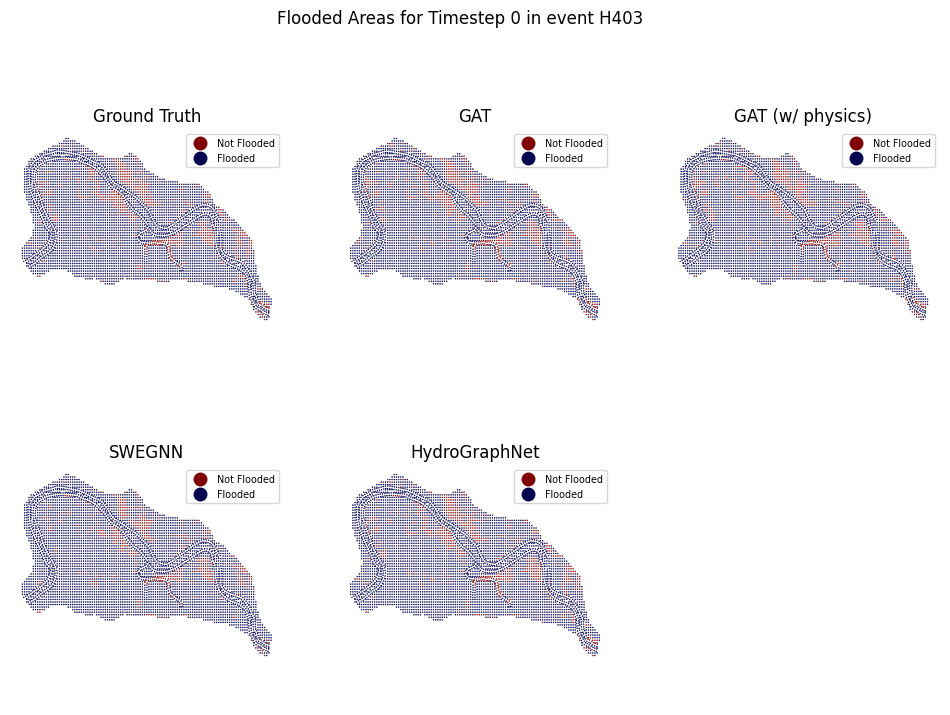

In [49]:
def convert_water_depth_to_binary(water_depth: np.ndarray, water_threshold: float = 0.3) -> np.ndarray:
    is_flooded_int = (water_depth > water_threshold).astype(int)
    is_flooded_str = pd.cut(is_flooded_int, bins=[-1, 0, 1], labels=['Not Flooded', 'Flooded'])
    return is_flooded_str

def plot_cell_map(axis, node_df: gpd.GeoDataFrame, value: np.ndarray, title: str):
    value_column = 'is_flooded'
    cmap = plt.get_cmap('seismic_r') 
    shared_plot_kwargs = {
        'cmap': cmap,
        'column': value_column,
        'linewidth': 0.3,
        'markersize': 0.5,
        'legend': True,
        'legend_kwds': {
            'loc': 'upper right',
            'fontsize': 'x-small',
        },
    }
    node_df[value_column] = value

    node_df.plot(ax=axis, **shared_plot_kwargs)
    axis.set_title(title)
    axis.set_axis_off()

def plot_flooded_areas_for_all_models(node_df: gpd.GeoDataFrame, metric_paths: list[str], timestep: int, ground_truth: torch.Tensor = None, water_threshold: float = 0.3, labels: list[str] = None):
    event_name = metric_paths[0].split('/')[-1].split('_')[1]
    ncols = 3
    num_plots = len(metric_paths) + (1 if ground_truth is not None else 0)
    nrows = (num_plots + ncols - 1) // ncols
    assert ncols * nrows >= len(metric_paths) + (1 if ground_truth is not None else 0), f"Not enough subplots for {len(metric_paths)} metrics"

    fig, ax = plt.subplots(figsize=(12,8), ncols=ncols, nrows=nrows)
    fig.suptitle(f'Flooded Areas for Timestep {timestep} in event {event_name}')
    index = 0

    if ground_truth is not None:
        binary_gt = convert_water_depth_to_binary(ground_truth[timestep, :, :].squeeze(), water_threshold)
        ax_row = index // ncols
        ax_col = index % ncols
        plot_cell_map(ax[ax_row, ax_col], node_df, binary_gt, title='Ground Truth')
        index += 1

    data_shape = None
    for i, path in enumerate(metric_paths):
        pred = np.load(path, allow_pickle=True)['pred']
        if data_shape is None:
            data_shape = pred.shape
        assert pred.shape == data_shape, f"Data shape mismatch: {pred.shape} vs {data_shape}"

        binary_pred = convert_water_depth_to_binary(pred[timestep, :, :].squeeze(), water_threshold)
        title = path.split('/')[-1].split('_')[0]

        if labels is not None:
            title = labels[i] if i < len(labels) else title

        ax_row = index // ncols
        ax_col = index % ncols
        plot_cell_map(ax[ax_row, ax_col], node_df, binary_pred, title=title)
        index += 1

    while index < (nrows * ncols):
        ax_row = index // ncols
        ax_col = index % ncols
        ax[ax_row, ax_col].axis('off')
        index += 1

    plt.show()

TIMESTEP = 0
ground_truth = np.load(metric_paths[0], allow_pickle=True)['target']
plot_flooded_areas_for_all_models(node_df, metric_paths, timestep=TIMESTEP, ground_truth=ground_truth, water_threshold=0.05, labels=labels)

### Train metrics